# Word repetition memory

This builds on the P50 and P300 example.

Procedure:
  A category prompt is presented, e.g. "large river" or "part of a foot". After a 3 s pause the probe word is
  presented, e.g., "toe" followed by a verbal Yes or No indicating whether the word fit the category.

Design

* half the probe words are congruous with the prompt, half are incongruous
* the prompt-probe word pairs are presented one, two, or three times
* repeated prompt-probe word pairs are presented at short and long lags


Event code tagging

* each probe word has a unique integer event code
* the codemap patterns tag individual words for item analysis
* event tags include the prompt and probe word stimulus


In [1]:
import os
import sys
from pathlib import Path
import re
import numpy as np
import pandas as pd
import mkpy
import spudtr

from matplotlib import pyplot as plt
from mkpy import mkh5
from spudtr import epf

# path wrangling for nbsphinx
if "MDE_HOME" in os.environ.keys():
    MDE_HOME = Path(os.environ["MDE_HOME"])
else:
    from conf import MDE_HOME

DOCS_DATA = MDE_HOME / "docs/_data"
    
print(os.environ["CONDA_DEFAULT_ENV"])
print(sys.version)
for pkg in [np, pd, mkpy, spudtr]:
    print(pkg.__name__, pkg.__version__, pkg.__file__)

mkpy_data_examples_101821
3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) 
[GCC 9.4.0]
numpy 1.21.2 /home/turbach/miniconda3/envs/mkpy_data_examples_101821/lib/python3.8/site-packages/numpy/__init__.py
pandas 1.3.4 /home/turbach/miniconda3/envs/mkpy_data_examples_101821/lib/python3.8/site-packages/pandas/__init__.py
mkpy 0.2.6 /home/turbach/miniconda3/envs/mkpy_data_examples_101821/lib/python3.8/site-packages/mkpy/__init__.py
spudtr 0.1.0 /home/turbach/miniconda3/envs/mkpy_data_examples_101821/lib/python3.8/site-packages/spudtr/__init__.py


In [2]:
# set filenames
crw = MDE_HOME / "mkdig/sub000wr.crw"    # EEG recording
log = MDE_HOME / "mkdig/sub000wr.x.log"  # events 
yhdr = MDE_HOME / "mkpy/sub000wr.yhdr"   # extra header info

# set calibration data filenames
cals_crw = MDE_HOME / "mkdig/sub000c.crw"
cals_log = MDE_HOME / "mkdig/sub000c.x.log"
cals_yhdr = MDE_HOME / "mkpy/sub000c.yhdr"

# HDF5 file with EEG recording, events, and header
wr_h5_f = DOCS_DATA / "sub000wr.h5"  

**mkh5**  EEG data, event code log, header information

In [3]:
# convert to HDF5
wr_h5 = mkh5.mkh5(wr_h5_f)
wr_h5.reset_all()
wr_h5.create_mkdata("sub000", crw, log, yhdr)

# add calibration data
wr_h5.append_mkdata("sub000", cals_crw, cals_log, cals_yhdr)

# calibrate
pts, pulse, lo, hi, ccode = 5, 10, -40, 40, 0
wr_h5.calibrate_mkdata(
    "sub000",  # data group to calibrate with these cal pulses
    n_points=pts,  # pts to average
    cal_size=pulse,  # uV
    lo_cursor=lo,  # lo_cursor ms
    hi_cursor=hi,  # hi_cursor ms
    cal_ccode=ccode,  # condition code
)

/home/turbach/miniconda3/envs/mkpy_data_examples_101821/lib/python3.8/site-packages/mkpy/mkh5.py:3669: UserWarning: negative event code(s) found for cal condition code 0 -16384
  warnings.warn(msg)


Found cals in /sub000/dblock_2
Calibrating block /sub000/dblock_0 of 3: (311040,)  


Calibrating block /sub000/dblock_1 of 3: (334592,)  


Calibrating block /sub000/dblock_2 of 3: (28416,)  


**codemap: single trial item analysis**


Simple YAML codemaps are fine for simple categorical designs with a few kinds of codes.

To tag single trials with design categories AND individual item attributes for hundreds of stimuli it may be easier to create (and check) the code map in an .xlsx spreadsheet with the help of formulas and macros.

The complexity of the design (8 conditions_ is multiplied by the number of individual items (216)

There are 1738 individual `pattern : tags` which an be created, stored, managed, and checked in a spreadsheet like so:

![word repetition codemap xlsx screenshot](_static/images/wr_codemap_xlsx_screenshot.png)

**1. get_event_table(*codemap*)** 

Scan the event codes for pattern matches and collect the HDF5 index, matching code, and tags

Event table modifications are not needed for this simple design.

In [4]:
wr_event_table = wr_h5.get_event_table(MDE_HOME / "mkpy/wr_codemap.xlsx")

/home/turbach/miniconda3/envs/mkpy_data_examples_101821/lib/python3.8/site-packages/mkpy/mkh5.py:1060: UserWarning: 
As of mkpy 0.2.0 to match events with a codemap regexp pattern, the
ccode column in wr_codemap.xlsx must also match the log_ccode
in the datablock. If this behavior is not desired, delete or rename
the ccode column in the codemap.
  warnings.warn(msg)


searching codes in: sub000/dblock_0


searching codes in: sub000/dblock_1


searching codes in: sub000/dblock_2


**inspect the event table**

In [5]:
print(wr_event_table.shape)
print(wr_event_table.columns)

# select some columns to show
example_columns = [
    "dblock_path", "dblock_ticks", "log_evcodes", "log_ccodes", "log_flags", 
    "regexp", "match_code", 
    "instrument", "item_id", "probe", "congruity", "repetition",
]

# first few stimulus events
display(wr_event_table[example_columns].head())

# last few calibration pulse events
display(wr_event_table[example_columns].tail())



pd.crosstab(
    [
        wr_event_table.instrument, 
        wr_event_table.ccode, 
        wr_event_table.repetition, 
        wr_event_table.pres_position, 
        wr_event_table.word_lag,
    ],
    [
        wr_event_table.log_flags
    ],
    margins=True
)

(497, 35)
Index(['data_group', 'dblock_path', 'dblock_tick_idx', 'dblock_ticks',
       'crw_ticks', 'raw_evcodes', 'log_evcodes', 'log_ccodes', 'log_flags',
       'epoch_match_tick_delta', 'epoch_ticks', 'dblock_srate', 'match_group',
       'idx', 'dlim', 'anchor_str', 'match_str', 'anchor_code', 'match_code',
       'anchor_tick', 'match_tick', 'anchor_tick_delta', 'is_anchor', 'regexp',
       'ccode', 'instrument', 'repetition', 'pres_position', 'word_lag',
       'congruity', 'event_code', 'condition_id', 'item_id', 'category',
       'probe'],
      dtype='object')


,dblock_path,dblock_ticks,log_evcodes,log_ccodes,log_flags,regexp,match_code,instrument,item_id,probe,congruity,repetition
144,sub000/dblock_0,219511,2009,2,0,(#2009),2009,eeg,9,bitter,congruent,initial
146,sub000/dblock_0,223966,3009,2,0,(#3009),3009,eeg,9,bitter,congruent,repeated
148,sub000/dblock_0,266277,8010,2,0,(#8010),8010,eeg,10,addict,incongruent,initial
150,sub000/dblock_0,276597,9010,2,0,(#9010),9010,eeg,10,addict,incongruent,repeated
152,sub000/dblock_0,108673,1011,2,0,(#1011),1011,eeg,11,blanket,congruent,initial


,dblock_path,dblock_ticks,log_evcodes,log_ccodes,log_flags,regexp,match_code,instrument,item_id,probe,congruity,repetition
1068,sub000/dblock_2,27315,4,0,0,(#\d+),4,cal,-1,cal,cal,cal
1069,sub000/dblock_2,27444,2,0,0,(#\d+),2,cal,-1,cal,cal,cal
1070,sub000/dblock_2,27573,3,0,0,(#\d+),3,cal,-1,cal,cal,cal
1071,sub000/dblock_2,27703,4,0,0,(#\d+),4,cal,-1,cal,cal,cal
1072,sub000/dblock_2,27832,2,0,0,(#\d+),2,cal,-1,cal,cal,cal


log_flags                                             0  32  48  64  All
instrument ccode repetition pres_position word_lag                      
cal        0     cal        cal           cal       208   0   0   1  209
eeg        2     initial    first         long       21   3   0   0   24
                                          short      24   0   0   0   24
                                          unique     24   0   0   0   24
                 repeated   second        long       21   3   0   0   24
                                          short      22   1   1   0   24
                            third         long       21   3   0   0   24
           3     initial    first         long       20   4   0   0   24
                                          short      22   2   0   0   24
                                          unique     23   1   0   0   24
                 repeated   second        long       22   2   0   0   24
                                          short      21   3   0   0   24
                            third         long       19   5   0   0   24
All                                                 468  27   1   1  497

**2. set_epochs(*name*, *pre*, *post*)**

Stash the the event table events and tags with a name and epoch interval boundaries.

In [6]:
wr_h5.set_epochs("ms1500", wr_event_table, -750, 750)

Sanitizing event table data types for mkh5 epochs table ...


/home/turbach/miniconda3/envs/mkpy_data_examples_101821/lib/python3.8/site-packages/mkpy/mkh5.py:1516: UserWarning: data error: pre-stimulus interval is out of bounds left ... skipping epoch (288, b'sub000', b'sub000/dblock_2', 0, 26, 26, 2, 2, 0, 64, -187, 375, 250., 1, 0, 1, b'2', b'2', 2, 2, 26, 26, 0, True, b'(#\\d+)', 0, b'cal', b'cal', b'cal', b'cal', b'cal', -1, 0, -1, b'cal', b'cal', 0, 0, 0, 26, -187, 375)
  warnings.warn(


**3. export_epochs(*name*, *file_format=...*)** 

Export the time-stamped, tagged, fixed-length segments of EEG data for analysis as HDF5, pandas HDF5 or feather

In [7]:
wr_epochs_f = DOCS_DATA / "sub000wr.ms1500.epochs.feather"
wr_h5.export_epochs("ms1500", wr_epochs_f, file_format="feather")        

**analyze the epochs**

* Is there a difference between congruous and incongrous probes?

* If so, is the effect the same for first and repeated presentations?

In [8]:
from matplotlib import pyplot as plt
from spudtr import epf
plt.style.use('bmh')

wr_epochs = pd.read_feather(wr_epochs_f)
# sanitize Epoch_idx for pandas index
wr_epochs['epoch_id'] = wr_epochs['epoch_id'].astype('int')

# 26 cap + EOG and A2 channel labels
wr_chans = [col for col in wr_epochs.columns if re.match(r"^[MLRAHlr]\w{1,3}$", col)]
print(f"n channels: {len(wr_chans)}\nchannels:{wr_chans}")

# lookup the epochs with stim events at time == 0) and clean artifact flags (= 0)
good_epoch_ids = wr_epochs.query("match_time == 0 and log_flags == 0").epoch_id

# select just the good epochs
wr_epochs = wr_epochs.query("epoch_id in @good_epoch_ids and ccode > 0").copy()

# check the good event counts after dropping artifacts
wr_good_events = wr_epochs.query("match_time == 0")

print("After excluding EEG artifacts")
pd.crosstab(
    [
        wr_good_events.instrument, 
        wr_good_events.ccode, 
        wr_good_events.pres_position, 
        wr_good_events.word_lag,
    ],
    [
        wr_good_events.log_flags
    ],
    margins=True
)

n channels: 32
channels:['lle', 'lhz', 'MiPf', 'LLPf', 'RLPf', 'LMPf', 'RMPf', 'LDFr', 'RDFr', 'LLFr', 'RLFr', 'LMFr', 'RMFr', 'LMCe', 'RMCe', 'MiCe', 'MiPa', 'LDCe', 'RDCe', 'LDPa', 'RDPa', 'LMOc', 'RMOc', 'LLTe', 'RLTe', 'LLOc', 'RLOc', 'MiOc', 'A2', 'HEOG', 'rle', 'rhz']
After excluding EEG artifacts


log_flags                                  0  All
instrument ccode pres_position word_lag          
eeg        2     first         long       21   21
                               short      24   24
                               unique     24   24
                 second        long       21   21
                               short      22   22
                 third         long       21   21
           3     first         long       20   20
                               short      22   22
                               unique     23   23
                 second        long       22   22
                               short      21   21
                 third         long       19   19
All                                      260  260

In [9]:
midline = ["MiPf", "MiCe", "MiPa", "MiOc"]

# some factors of interest
midline_epochs = wr_epochs[
    ["epoch_id", "match_time", "congruity", "repetition", "pres_position", "word_lag"] + midline
]
# center each channel prestimulus
midline_epochs = epf.center_eeg(
    midline_epochs, 
    midline, 
    -750, 0, 
    epoch_id="epoch_id", 
    time="match_time"
)

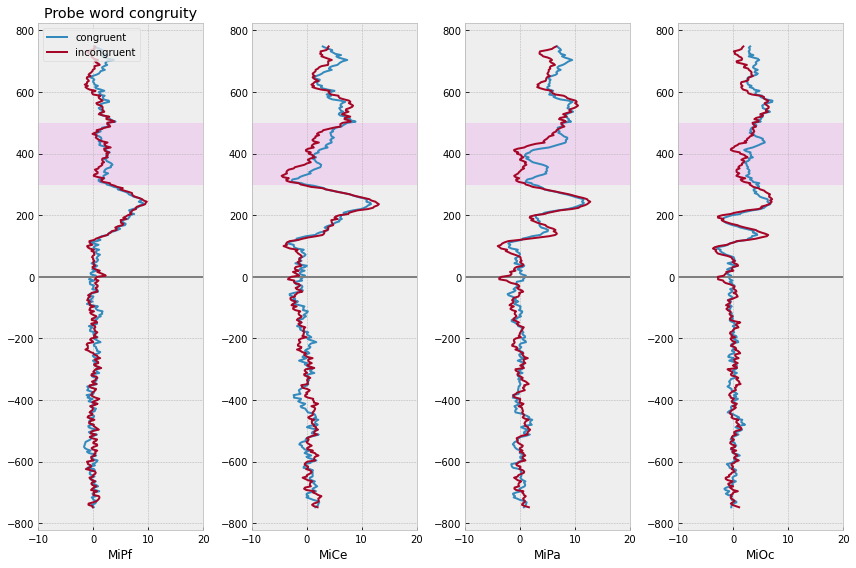

In [10]:
# compute domain average by stim type
midline_erps = midline_epochs.groupby(
    ["congruity", "match_time"]
).mean().reset_index()

# plot
f, axs = plt.subplots(1, 4, figsize=(12,8))

for rep, erp in midline_erps.groupby(["congruity"]):
    for axi, chan in enumerate(midline):
        
        # mark onset
        axs[axi].axhline(0, color='gray')
        
        axs[axi].plot(
            erp[chan],
            erp["match_time"],
            label=f"{rep}",
            lw=2,
        )
        
        axs[axi].set(xlim=(-10, 20), xlabel=chan)
        axs[axi].axhspan(300, 500, color="magenta", alpha=.05)

axs[0].legend(loc="upper left")
axs[0].set_title("Probe word congruity")
f.tight_layout()

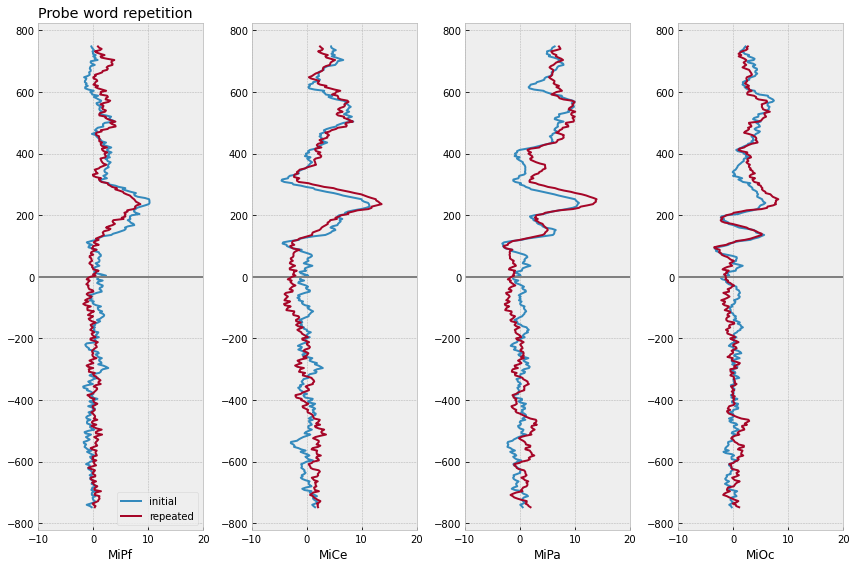

In [11]:
# compute domain average by stim type
midline_erps = midline_epochs.groupby(
    ["repetition", "match_time"]
).mean().reset_index()

# plot
f, axs = plt.subplots(1, 4, figsize=(12,8))

for rep, erp in midline_erps.groupby(["repetition"]):
    for axi, chan in enumerate(midline):
        
        # mark onset
        axs[axi].axhline(0, color='gray')
        
        axs[axi].plot(
            erp[chan],
            erp["match_time"],
            label=f"{rep}",
            lw=2,
        )
        axs[axi].set(xlim=(-10, 20), xlabel=chan)

axs[0].legend(loc="lower right")
axs[0].set_title("Probe word repetition", loc='left')
f.tight_layout()


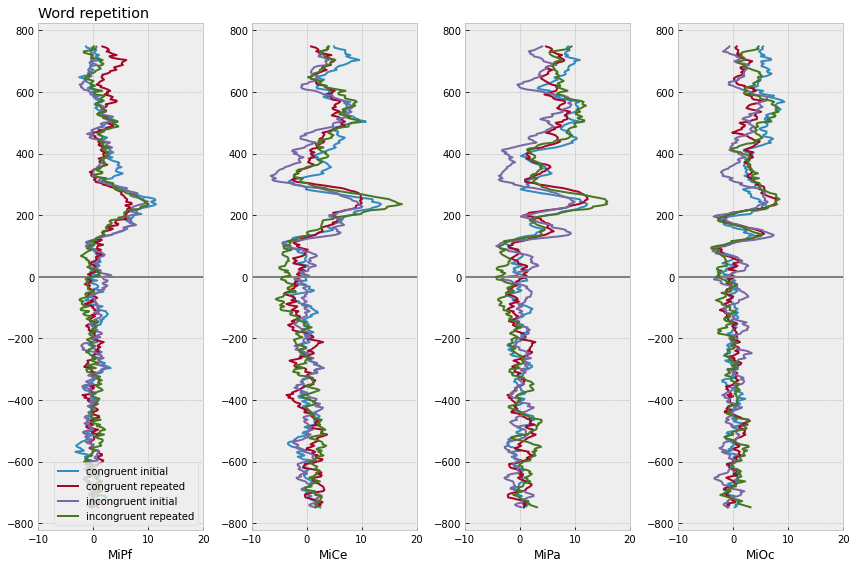

In [12]:
midline_erps = midline_epochs.groupby(
    ["congruity", "repetition", "match_time"]
).mean().reset_index()

# plot
f, axs = plt.subplots(1, 4, figsize=(12,8))

for (congruity, repetition), erp in midline_erps.groupby(['congruity', "repetition"]):
    for axi, chan in enumerate(midline):
        
        # mark onset
        axs[axi].axhline(0, color='gray')
        
        axs[axi].plot(
            erp[chan],
            erp["match_time"],
            label=f"{congruity} {repetition}",
            lw=2,
        )
        
        axs[axi].set(xlim=(-10, 20), xlabel=chan)

axs[0].legend(loc="lower right")
axs[0].set_title("Word repetition", loc='left')
f.tight_layout()
    